# Authors: Yijun Wang, Owen Xu
# Datetime: 2020/02/15 12:00

# Assumption
### Assume homogeneous features across cities. Real life situations such as medical shortage that defers the time of confirm or even fail to confirm infectious individuals unevenly across cities would make the forecast biased. 
### Assume the start of the epidemic in Wuhan is on Dec 1, 2019 and the rest of the cities is Jan 23, 2020
### Except for Wuhan, assume the number of infectious on Jan 23, 2020 is equivalent to the confirm counts on Jan 23, 2020
### Assume that infected individuals were not infectious during the incubation period (Zhou, 2020)
### Assume close environment for each individual city
### Assume population growth and death rate are zero

# Parameter value
### Initial R0 takes the value of 3.0, while research varies from 2.2 to 3.8
### Current or trending R0 refers to model "Estimation of R0" at datetime 8:42 am 02-14-2020
### Wuhan population refers to https://baijiahao.baidu.com/s?id=1656943894281117716&wfr=spider&for=pc
### Beijing population refers to Beijing Population. (2019-05-12). Retrieved 2020-02-14, from http://worldpopulationreview.com/world-cities/beijing/
### Shanghai population refers to Shanghai Population. (2019-05-12). Retrieved 2020-02-14, from http://worldpopulationreview.com/world-cities/shanghai/

# Data
### API from BlankerL and data comes from Ding Xiang Yuan

# R0

In [4]:
# load data
import requests
import pandas as pd

url = 'https://lab.isaaclin.cn/nCoV/api/overall?latest=1'
r = requests.request('GET', url)
data = r.json()
df = pd.DataFrame.from_records(data['results'])
from datetime import datetime
import pandas

# date
df['t'] = pandas.to_datetime(df['updateTime']/1000,unit='s')
import datetime
df['date'] = df['t'].dt.date

# days: 疾病已爆发时间
import datetime
df['days'] = (df['updateTime']/1000 - datetime.datetime(2019,12,1,0,0,0).timestamp())/60/60/24

# generation time
Tg = 7.5
# latent period
Tl = 3
# infectious period
Ti = Tg - Tl
# calculate R0
import math
def R0Func(confirm, suspect,t):
    # confirm是确诊人数；susp是疑似人数；t是疾病已爆发时间
    # p为疑似病例转化为确诊病例的概率
    p = 0.695
    # rho is the over incubation period over generation time
    rho = Tl/Tg
    # yt为实际预估感染人数
    yt = suspect * p + confirm
    # lamda为早期指数增长的增长率
    lamda = math.log(yt)/t    
    R0 = 1 + lamda * Tg + rho * (1 - rho) * pow(lamda * Tg,2)   
    return R0

df['R0'] = df.apply(lambda x: R0Func(x['confirmedCount'], x['suspectedCount'], x['days']), axis = 1)
df

,infectSource,passWay,dailyPic,dailyPics,summary,countRemark,currentConfirmedCount,confirmedCount,suspectedCount,curedCount,...,generalRemark,abroadRemark,marquee,quanguoTrendChart,hbFeiHbTrendChart,updateTime,t,date,days,R0
0,该字段已替换为说明2,该字段已替换为说明3,https://img1.dxycdn.com/2020/0211/763/33959988...,[https://img1.dxycdn.com/2020/0211/763/3395998...,,,56642,66580,8969,8414,...,疑似病例数来自国家卫健委数据，目前为全国数据，未分省市自治区等,,"[{'id': 422, 'marqueeLabel': '公告', 'marqueeCon...",[{'imgUrl': 'https://img1.dxycdn.com/2020/0215...,[{'imgUrl': 'https://img1.dxycdn.com/2020/0215...,1581766807231,2020-02-15 11:40:07.230999947,2020-02-15,76.819528,2.379789


# SEIR
### Setup

In [24]:
import scipy.integrate as spi
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# differential equations
def SEIR(inivalue, _):
    Y = np.zeros(4)
    X = inivalue
    # dS/dt
    Y[0] = - (beta * X[0] * X[2]) / N
    # dE/dt
    Y[1] = (beta * X[0] * X[2]) / N - X[1] / Tg
    # dI/dt
    Y[2] = X[1] / Tg - gamma * X[2]
    # dR/dt
    Y[3] = gamma * X[2]
    return Y
# T为传播时间
T = 300
Time = np.arange(0, T + 1)
# R0 is basic reproduction number
from pandas import DataFrame
R0 = df.iloc[len(df)-1,df.shape[1]-1]

# beta is effective contact rate 
def betaFunc(R0 = R0, Ti = Ti):
    return R0/Ti
# gamma is removal rate
def gammaFunc(Tg = Tg):
    return 1/Tg
gamma = gammaFunc()

# create dates
from datetime import date
import datetime
start_day_wuhan = date(2019, 12, 1)
dates_wuhan = [start_day_wuhan + datetime.timedelta(n) for n in range(T + 1)]

start_day = date(2020, 1, 23)
dates = [start_day + datetime.timedelta(n) for n in range(T + 1)]

# Wuhan Trending

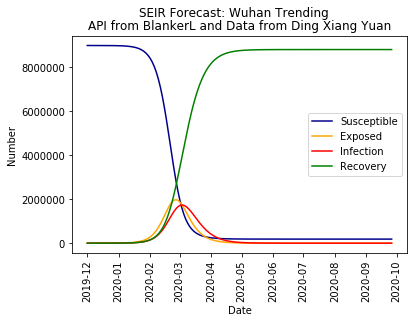

2.3797887189661946 0.5288419375480432 1734367.859710823 93 2020-03-03


In [48]:
# R0 is basic reproduction number
from pandas import DataFrame
R0 = df.iloc[len(df)-1,df.shape[1]-1]
# beta is effective contact rate
beta = betaFunc(R0)
N = 9000000
I = 86
INI = (N, 0, I, 0)
# solve the system of differential equations
RES = spi.odeint(SEIR, INI, Time)

plt.plot(dates_wuhan, RES[:,0],color = 'darkblue',label = 'Susceptible')
plt.plot(dates_wuhan, RES[:,1],color = 'orange',label = 'Exposed')
plt.plot(dates_wuhan, RES[:,2],color = 'red',label = 'Infection')
plt.plot(dates_wuhan, RES[:,3],color = 'green',label = 'Recovery')

plt.title('API from BlankerL and Data from Ding Xiang Yuan')
plt.suptitle('SEIR Forecast: Wuhan Trending')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Number')
plt.xticks(rotation=90)
plt.show()

print(R0, beta, max(RES[:,2]),np.argmax(RES[:,2]), start_day_wuhan + datetime.timedelta(int(np.argmax(RES[:,2]))))
# plt.savefig('wuhan.png')

# wuhan n/2

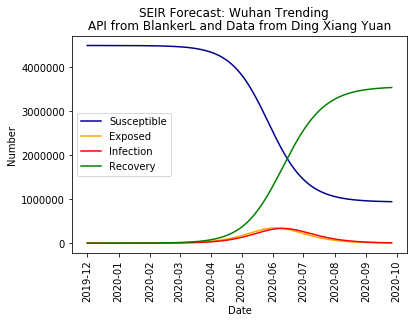

2.3797887189661946 0.5288419375480432 335692.2625504966 192 2020-06-10


In [47]:
R0 = df.iloc[len(df)-1,df.shape[1]-1]
beta = betaFunc(R0)
RES = spi.odeint(SEIR, (4500000, 0, 86, 0), Time)

plt.plot(dates_wuhan, RES[:,0],color = 'darkblue',label = 'Susceptible')
plt.plot(dates_wuhan, RES[:,1],color = 'orange',label = 'Exposed')
plt.plot(dates_wuhan, RES[:,2],color = 'red',label = 'Infection')
plt.plot(dates_wuhan, RES[:,3],color = 'green',label = 'Recovery')

plt.title('API from BlankerL and Data from Ding Xiang Yuan')
plt.suptitle('SEIR Forecast: Wuhan Trending')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Number')
plt.xticks(rotation=90)
plt.show()

print(R0, beta, max(RES[:,2]),np.argmax(RES[:,2]), start_day_wuhan + datetime.timedelta(int(np.argmax(RES[:,2]))))

# wuhan I/2

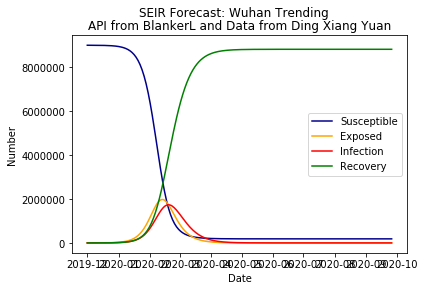

2.3797887189661946 0.5288419375480432 1735272.8862999086 80 2020-02-19


In [40]:
R0 = df.iloc[len(df)-1,df.shape[1]-1]
beta = betaFunc()
RES = spi.odeint(SEIR, (9000000, 0, 86/2, 0), Time)

plt.plot(dates_wuhan, RES[:,0],color = 'darkblue',label = 'Susceptible')
plt.plot(dates_wuhan, RES[:,1],color = 'orange',label = 'Exposed')
plt.plot(dates_wuhan, RES[:,2],color = 'red',label = 'Infection')
plt.plot(dates_wuhan, RES[:,3],color = 'green',label = 'Recovery')

plt.title('API from BlankerL and Data from Ding Xiang Yuan')
plt.suptitle('SEIR Forecast: Wuhan Trending')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Number')
plt.show()

print(R0, beta, max(RES[:,2]), np.argmax(RES[:,2]), start_day_wuhan + datetime.timedelta(int(np.argmax(RES[:,2]))))

# wuhan beta/2

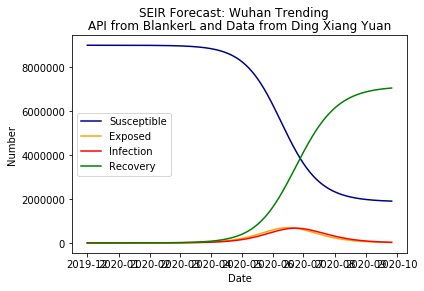

1.1898943594830973 0.2644209687740216 671406.7527047297 205 2020-06-23


In [41]:
# beta is effective contact rate
beta = betaFunc(R0)/2
R0 = beta * Ti
# solve the system of differential equations
RES = spi.odeint(SEIR, INI, Time)

plt.plot(dates_wuhan, RES[:,0],color = 'darkblue',label = 'Susceptible')
plt.plot(dates_wuhan, RES[:,1],color = 'orange',label = 'Exposed')
plt.plot(dates_wuhan, RES[:,2],color = 'red',label = 'Infection')
plt.plot(dates_wuhan, RES[:,3],color = 'green',label = 'Recovery')

plt.title('API from BlankerL and Data from Ding Xiang Yuan')
plt.suptitle('SEIR Forecast: Wuhan Trending')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Number')
plt.show()

print(R0, beta, max(RES[:,2]),np.argmax(RES[:,2]), start_day_wuhan + datetime.timedelta(int(np.argmax(RES[:,2]))))
#plt.savefig('wuhan.png')

# Guangzhou Trending

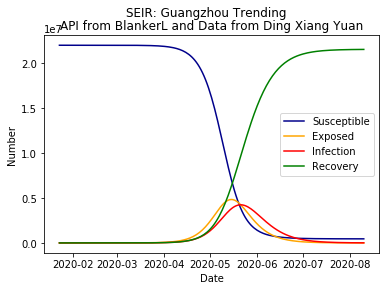

2.3797887189661946 0.5288419375480432 4241082.688534465 119 2020-05-21


In [13]:
N = 22000000
R0 = df.iloc[len(df)-1,df.shape[1]-1]
beta = betaFunc()
RES = spi.odeint(SEIR, (22000000, 0, 7, 0), Time)

plt.plot(dates, RES[:,0],color = 'darkblue',label = 'Susceptible')
plt.plot(dates, RES[:,1],color = 'orange',label = 'Exposed')
plt.plot(dates, RES[:,2],color = 'red',label = 'Infection')
plt.plot(dates, RES[:,3],color = 'green',label = 'Recovery')

plt.title('API from BlankerL and Data from Ding Xiang Yuan')
plt.suptitle('API from BlankerL and Data from Ding Xiang Yuan')
plt.suptitle('SEIR: Guangzhou Trending')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Number')
plt.show()

print(R0, beta, max(RES[:,2]),np.argmax(RES[:,2]), date(2020,1,23) + datetime.timedelta(int(np.argmax(RES[:,2]))))

# Beijing Trending

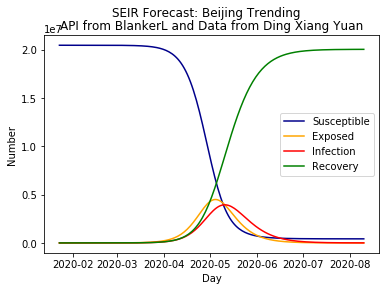

2.3797887189661946 0.5288419375480432 3943645.2231713305 109 2020-05-11


In [14]:
N = 20462610
R0 = df.iloc[len(df)-1,df.shape[1]-1]
beta = betaFunc()
INI = (20462610, 0, 26, 0)
RES = spi.odeint(SEIR, INI, Time)

plt.plot(dates, RES[:,0],color = 'darkblue',label = 'Susceptible')
plt.plot(dates, RES[:,1],color = 'orange',label = 'Exposed')
plt.plot(dates, RES[:,2],color = 'red',label = 'Infection')
plt.plot(dates, RES[:,3],color = 'green',label = 'Recovery')

plt.title('API from BlankerL and Data from Ding Xiang Yuan')
plt.suptitle('SEIR Forecast: Beijing Trending')
plt.legend()
plt.xlabel('Day')
plt.ylabel('Number')
plt.show()

print(R0, beta, max(RES[:,2]),np.argmax(RES[:,2]), date(2020,1,23) + datetime.timedelta(int(np.argmax(RES[:,2]))))

# Shanghai Trending

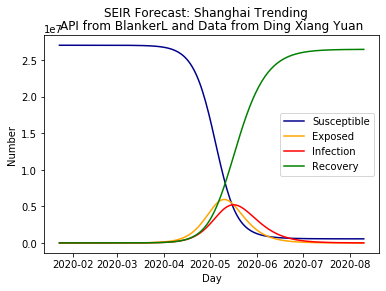

2.3797887189661946 0.5288419375480432 5213689.953632764 114 2020-05-16


In [15]:
N = 27058479
R0 = df.iloc[len(df)-1,df.shape[1]-1]
beta = betaFunc()
INI = (27058479, 0, 16, 0)
RES = spi.odeint(SEIR, INI, Time)

plt.plot(dates, RES[:,0],color = 'darkblue',label = 'Susceptible')
plt.plot(dates, RES[:,1],color = 'orange',label = 'Exposed')
plt.plot(dates, RES[:,2],color = 'red',label = 'Infection')
plt.plot(dates, RES[:,3],color = 'green',label = 'Recovery')

plt.title('API from BlankerL and Data from Ding Xiang Yuan')
plt.suptitle('SEIR Forecast: Shanghai Trending')
plt.legend()
plt.xlabel('Day')
plt.ylabel('Number')
plt.show()

print(R0, beta, max(RES[:,2]),np.argmax(RES[:,2]), date(2020,1,23) + datetime.timedelta(int(np.argmax(RES[:,2]))))